In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
#x_train[0:1000]
#time_train[0:100]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.], dtype=float32)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 6s 12ms/step - loss: 73.2144 - mae: 73.7136
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 71.8829 - mae: 72.3820
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 71.1747 - mae: 71.6739
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 69.8038 - mae: 70.3031
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 69.3436 - mae: 69.8427
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 66.7656 - mae: 67.2644
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 64.1345 - mae: 64.6338
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 62.0534 - mae: 62.5524
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 59.5496 - mae: 60.0484
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 56.8676 - mae: 57.3663
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 11ms/step - loss: 21.8630 - mae: 22.3592
Epoch 88/100
8/8 [==============================] - 0s 11ms/step - loss: 19.8013 - mae: 20.2967
Epoch 89/100
8/8 [==============================] - 0s 11ms/step - loss: 15.0009 - mae: 15.4942
Epoch 90/100
8/8 [==============================] - 0s 11ms/step - loss: 22.5346 - mae: 23.0295
Epoch 91/100
8/8 [==============================] - 0s 12ms/step - loss: 20.0956 - mae: 20.5917
Epoch 92/100
8/8 [==============================] - 0s 11ms/step - loss: 18.8641 - mae: 19.3585
Epoch 93/100
8/8 [==============================] - 0s 11ms/step - loss: 22.8361 - mae: 23.3304
Epoch 94/100
8/8 [==============================] - 0s 11ms/step - loss: 20.0042 - mae: 20.4992
Epoch 95/100
8/8 [==============================] - 0s 11ms/step - loss: 15.0834 - mae: 15.5761
Epoch 96/100
8/8 [==============================] - 0s 11ms/step - loss: 14.8131 - mae: 15.3054
Epoch 97/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

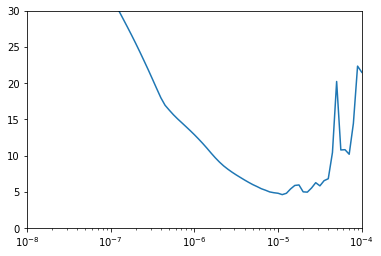

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 3s 8ms/step - loss: 33.5999 - mae: 34.0956
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 8.4929 - mae: 8.9781
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 6.9030 - mae: 7.3851
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 6.3056 - mae: 6.7856
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 5.7222 - mae: 6.2020
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 5.7025 - mae: 6.1824
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 5.5303 - mae: 6.0102
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 5.3713 - mae: 5.8509
Epoch 9/500
31/31 [==============================] - 0s 7ms/step - loss: 5.4090 - mae: 5.8890
Epoch 10/500
31/31 [==============================] - 0s 7ms/step - loss: 5.1304 - mae: 5.6096
Epoch 11/500
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 7ms/step - loss: 4.3844 - mae: 4.8599
Epoch 88/500
31/31 [==============================] - 0s 7ms/step - loss: 4.2444 - mae: 4.7200
Epoch 89/500
31/31 [==============================] - 0s 7ms/step - loss: 4.2376 - mae: 4.7120
Epoch 90/500
31/31 [==============================] - 0s 7ms/step - loss: 4.2323 - mae: 4.7075
Epoch 91/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2685 - mae: 4.7435
Epoch 92/500
31/31 [==============================] - 0s 7ms/step - loss: 4.3766 - mae: 4.8532
Epoch 93/500
31/31 [==============================] - 0s 7ms/step - loss: 4.1989 - mae: 4.6739
Epoch 94/500
31/31 [==============================] - 0s 7ms/step - loss: 4.4400 - mae: 4.9157
Epoch 95/500
31/31 [==============================] - 0s 7ms/step - loss: 4.2693 - mae: 4.7444
Epoch 96/500
31/31 [==============================] - 0s 7ms/step - loss: 4.1915 - mae: 4.6652
Epoch 97/500
31/31 [==============================] - 0s 7ms/st

31/31 [==============================] - 0s 7ms/step - loss: 4.1150 - mae: 4.5883
Epoch 173/500
31/31 [==============================] - 0s 6ms/step - loss: 4.0833 - mae: 4.5561
Epoch 174/500
31/31 [==============================] - 0s 7ms/step - loss: 4.1759 - mae: 4.6504
Epoch 175/500
31/31 [==============================] - 0s 7ms/step - loss: 4.1716 - mae: 4.6467
Epoch 176/500
31/31 [==============================] - 0s 7ms/step - loss: 4.1187 - mae: 4.5916
Epoch 177/500
31/31 [==============================] - 0s 7ms/step - loss: 4.1105 - mae: 4.5843
Epoch 178/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0904 - mae: 4.5633
Epoch 179/500
31/31 [==============================] - 0s 7ms/step - loss: 4.3395 - mae: 4.8161
Epoch 180/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0678 - mae: 4.5402
Epoch 181/500
31/31 [==============================] - 0s 7ms/step - loss: 4.1213 - mae: 4.5949
Epoch 182/500
31/31 [==============================] -

31/31 [==============================] - 0s 7ms/step - loss: 4.0754 - mae: 4.5490
Epoch 258/500
31/31 [==============================] - 0s 8ms/step - loss: 4.0665 - mae: 4.5398
Epoch 259/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0094 - mae: 4.4823
Epoch 260/500
31/31 [==============================] - 0s 7ms/step - loss: 3.9868 - mae: 4.4603
Epoch 261/500
31/31 [==============================] - 0s 7ms/step - loss: 4.1196 - mae: 4.5933
Epoch 262/500
31/31 [==============================] - 0s 8ms/step - loss: 4.1163 - mae: 4.5902
Epoch 263/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0158 - mae: 4.4891
Epoch 264/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0510 - mae: 4.5243
Epoch 265/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0238 - mae: 4.4963
Epoch 266/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0674 - mae: 4.5413
Epoch 267/500
31/31 [==============================] -

31/31 [==============================] - 0s 7ms/step - loss: 4.0064 - mae: 4.4798
Epoch 343/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0038 - mae: 4.4768
Epoch 344/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0453 - mae: 4.5185
Epoch 345/500
31/31 [==============================] - 0s 7ms/step - loss: 3.9733 - mae: 4.4471
Epoch 346/500
31/31 [==============================] - 0s 7ms/step - loss: 3.9440 - mae: 4.4164
Epoch 347/500
31/31 [==============================] - 0s 7ms/step - loss: 3.9480 - mae: 4.4190
Epoch 348/500
31/31 [==============================] - 0s 7ms/step - loss: 3.9945 - mae: 4.4674
Epoch 349/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0040 - mae: 4.4780
Epoch 350/500
31/31 [==============================] - 0s 7ms/step - loss: 3.9535 - mae: 4.4264
Epoch 351/500
31/31 [==============================] - 0s 7ms/step - loss: 3.9211 - mae: 4.3941
Epoch 352/500
31/31 [==============================] -

31/31 [==============================] - 0s 7ms/step - loss: 3.9653 - mae: 4.4378
Epoch 428/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0525 - mae: 4.5254
Epoch 429/500
31/31 [==============================] - 0s 6ms/step - loss: 3.9863 - mae: 4.4576
Epoch 430/500
31/31 [==============================] - 0s 6ms/step - loss: 4.0272 - mae: 4.5001
Epoch 431/500
31/31 [==============================] - 0s 6ms/step - loss: 3.9175 - mae: 4.3891
Epoch 432/500
31/31 [==============================] - 0s 7ms/step - loss: 3.9536 - mae: 4.4260
Epoch 433/500
31/31 [==============================] - 0s 7ms/step - loss: 3.9451 - mae: 4.4175
Epoch 434/500
31/31 [==============================] - 0s 6ms/step - loss: 4.0287 - mae: 4.5013
Epoch 435/500
31/31 [==============================] - 0s 6ms/step - loss: 4.0091 - mae: 4.4823
Epoch 436/500
31/31 [==============================] - 0s 6ms/step - loss: 3.9416 - mae: 4.4143
Epoch 437/500
31/31 [==============================] -

In [31]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print(type(rnn_forecast))
print(rnn_forecast.shape)
print(split_time - window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print(rnn_forecast.shape)

<class 'numpy.ndarray'>
(1432, 30, 1)
970
(461,)


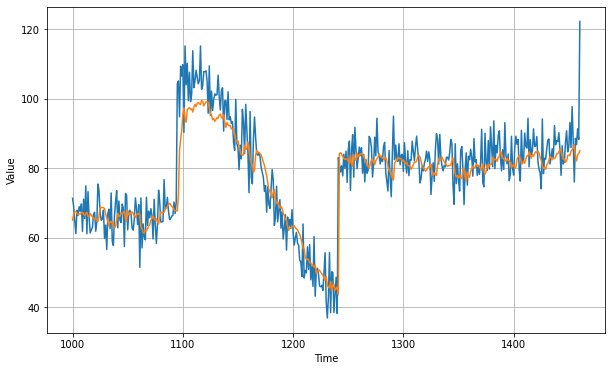

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0777855

<Figure size 432x288 with 0 Axes>

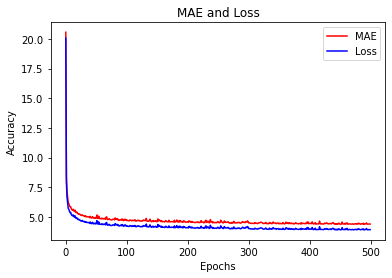

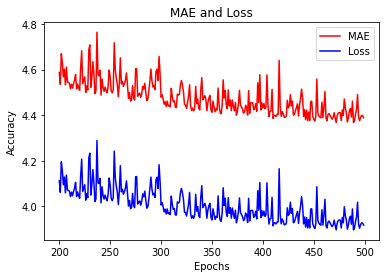

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()